In [9]:
import wandb
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import pdb

api = wandb.Api()

In [10]:
batch_sizes = [2**i for i in range(6, 15)]
model_size_names = ['85M', '151M-ablation', '302M', '604M', '1.2B']
goal_losses = {'85M': 3.42, '151M-ablation': 3.24, '302M': 3.07, '604M': 2.92, '1.2B': 2.736} 
goal_steps = {'85M': 13282, '151M-ablation': 23438, '302M': 46875, '604M': 93750, '1.2B': 187500}
wandb_path = "hanlin-ml/cbs" # Path to the wandb project 

results = {}
for model_size in model_size_names: 
    min_goal_steps = []
    for batch_size in batch_sizes: 
        # Can filter by config.*, summary_metrics.*, tags, state, entity, createdAt, etc.
        conditions = [{"group": f"cbs-{model_size}"}, {"config.global_train_batch_size": batch_size}, 
                      {"config.optimizer.use_swa": True}, {"config.model.max_sequence_length": 512}, 
                      {"config.scheduler.name": "constant"}]
        if model_size == '302M':
            conditions += [{"config.scheduler.warmup_ratio": 0.25}]
        runs = api.runs(path=wandb_path, 
                        filters={
                            "$and": conditions,
                        })
        min_goal_step = np.inf
        for run in runs:
            history = run.history(keys=["eval/c4-validation/CrossEntropyLoss",])
            if len(history) == 0:
                continue
            indices = list(history["eval/c4-validation/CrossEntropyLoss"] < goal_losses[model_size])
            if len(indices) == 0:
                continue

            steps = history[indices]
            if steps["_step"].min() < min_goal_step:
                min_goal_step = steps["_step"].min()
                min_run_name = run.name
                min_run_id = run.id
        print(run.name)
        print("Learning rate: ", run.config['optimizer']['learning_rate'])
        try:
            beta2 = run.config['optimizer']['beta2']
        except:
            beta2 = run.config['optimizer']['betas'][1]
            print("Beta 2 not found, using betas[1] for run : ", run.name, min_run_id)
        print("Beta 2: ", beta2)
        print("EWA decay: ", run.config['optimizer']['swa_decay'])

        min_goal_steps.append(min_goal_step)
        print(f"Minimum goal step {min_goal_step} for batch size {batch_size} (Model Size {model_size}, Run Name {min_run_name}), Run ID {min_run_id}")
        print()
    results[model_size] = min_goal_steps

bs64-adamw_0.95-lr0.00316-ewa0.99
Learning rate:  0.00316
Beta 2:  0.99
EWA decay:  0.99
Minimum goal step 46000 for batch size 64 (Model Size 85M, Run Name bs64-adamw_0.95-lr0.00316-ewa0.9995), Run ID n0wjhnb6

bs128-adamw_0.95-lr0.00316-ewa0.99
Learning rate:  0.00316
Beta 2:  0.99
EWA decay:  0.99
Minimum goal step 23000 for batch size 128 (Model Size 85M, Run Name bs128-adamw_0.95-lr0.00316-ewa0.9995), Run ID gkifmwoj

bs256-adamw_0.95-lr0.00316-ewa0.99
Learning rate:  0.00316
Beta 2:  0.99
EWA decay:  0.99
Minimum goal step 13282 for batch size 256 (Model Size 85M, Run Name bs256-adamw_0.95-lr0.00316-ewa), Run ID u9d1lmd4

bs512-adamw_0.95-lr0.00316-ewa0.99
Learning rate:  0.00316
Beta 2:  0.99
EWA decay:  0.99
Minimum goal step 7000 for batch size 512 (Model Size 85M, Run Name bs512-adamw_0.95-lr0.00316-ewa0.998), Run ID h75dyo33

bs1024-adamw_0.95-lr0.00316-ewa0.95
Learning rate:  0.00316
Beta 2:  0.95
EWA decay:  0.95
Minimum goal step 3840 for batch size 1024 (Model Size 85M, 

{'85M': [46000, 23000, 13282, 7000, 3840, 2500, 1800, 1600, 1600], '151M-ablation': [96000, 49000, 24000, 11951, 7128, 4200, 2760, 2400, 2300], '302M': [196000, 90000, 46000, 23400, 13300, 7224, 4980, 3400, 2879], '604M': [311000, 166000, 81000, 37440, 21320, 11400, 7199, 4700, 3800], '1.2B': [643000, 331000, 176000, 94000, 46500, 25000, 15360, 8900, 6500]}


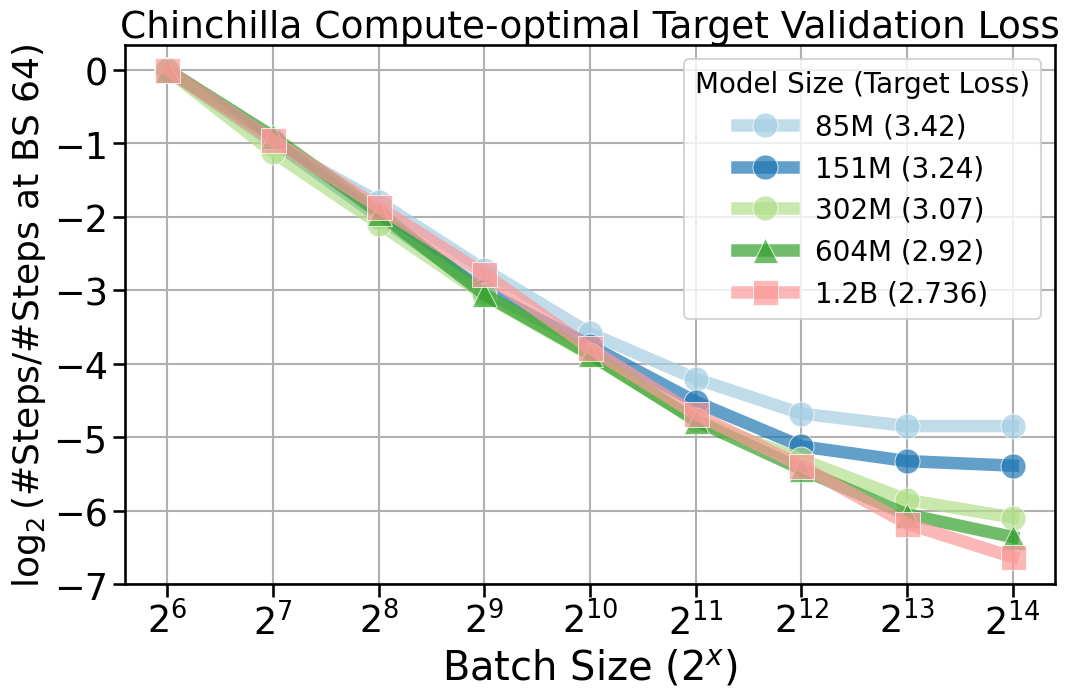

In [11]:
# Relative plots - making y-axis as # steps / # steps at batch size 64
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# replace np.inf with np.nan
for model_size in model_size_names:
    results[model_size] = [np.nan if x == np.inf else x for x in results[model_size]]
print(results)
# NOTE Model size ablation on chinchilla validation loss
all_plot_data = [
    {'batch_sizes': batch_sizes,
     'num_steps': results['85M'],
     'model_size': '85M',
     'goal_loss': goal_losses['85M']}, 
    {'batch_sizes': batch_sizes,
     'num_steps': results['151M-ablation'],
     'model_size': '151M',
     'goal_loss': goal_losses['151M-ablation']}, 
    {'batch_sizes': batch_sizes,
     'num_steps': results['302M'],
     'model_size': '302M',
     'goal_loss': goal_losses['302M']}, 
    {'batch_sizes': batch_sizes,
     'num_steps': results['604M'],
     'model_size': '604M',
     'goal_loss': goal_losses['604M']}, 
    {'batch_sizes': batch_sizes,
     'num_steps': results['1.2B'],
     'model_size': '1.2B',
     'goal_loss': goal_losses['1.2B']},
]
# a random sample
tmp_data = all_plot_data[-1]

# Calculate additional points based on the given relationship
halving_data = {
    'log2_batch_sizes': [6, 7, 8, 9, 10] + [11, 12, 13, 14],
    'num_steps': [53200]
}
current_num_steps = 53200
for i in range(1, len(tmp_data['num_steps'])):
    current_num_steps /= 2  # Halve the number of steps
    halving_data['num_steps'].append(current_num_steps)

# Convert to DataFrame
df_halving = pd.DataFrame(halving_data)
df_halving['log2_num_steps'] = np.log2(df_halving['num_steps'])

plt.figure(figsize=(12, 7))

palette_name = "Paired" 
sns.set_palette(palette_name) # Set a global color palette
sns.set_context("talk", font_scale=1.6)
plt.tight_layout()

markers = ['o', 'o', 'o', '^', 's']
linewidths = [9] * 5

for i, data in enumerate(all_plot_data):
    # Create a DataFrame
    df = pd.DataFrame(data)
    # Convert batch sizes to log2 scale
    df['log2_batch_sizes'] = np.log2(df['batch_sizes'])
    df['log2_num_steps'] = (np.log2(df['num_steps']) - np.log2(df['num_steps'][0]))
    plot = sns.lineplot(x='log2_batch_sizes', y='log2_num_steps', data=df, label=f'{df["model_size"][0]} ({df["goal_loss"][0]})',
                        alpha=.7, marker=markers[i], markersize=int(2*linewidths[i]), linewidth=linewidths[i])
    plot.set_xticks(df['log2_batch_sizes'])  # Set x-ticks to log2 batch sizes
    plot.set_xticklabels([f'$2^{{{int(x)}}}$' for x in df['log2_batch_sizes']]) # Format x-ticks with correct exponent format

# Set labels and title
plt.xlabel('Batch Size ($2^x$)')
plt.ylabel(fr'$\log_2$(#Steps/#Steps at BS 64)', fontsize=26)
plt.title('Chinchilla Compute-optimal Target Validation Loss', fontsize=27)
legend_fontsize = 'x-small'
plt.legend(title='Model Size (Target Loss)', loc='upper right', title_fontsize=legend_fontsize, fontsize=legend_fontsize)
plt.grid(True)

plt.yticks(np.arange(-7, 1, 1))
plt.savefig('rel_model_size_chin.pdf',  bbox_inches='tight')
plt.show()


{'85M': [46000, 23000, 13282, 7000, 3840], '151M-ablation': [96000, 49000, 24000, 11951, 7128], '302M': [196000, 90000, 46000, 23400, 13300], '604M': [311000, 166000, 81000, 37440, 21320], '1.2B': [643000, 331000, 176000, 94000, 46500]}
{'85M': [7000, 3840, 2500, 1800, 1600, 1600], '151M-ablation': [11951, 7128, 4200, 2760, 2400, 2300], '302M': [23400, 13300, 7224, 4980, 3400, 2879], '604M': [37440, 21320, 11400, 7199, 4700, 3800], '1.2B': [94000, 46500, 25000, 15360, 8900, 6500]}
{'85M': [7000, 3840, 2500, 1800, 1600, 1600], '151M-ablation': [11951, 7128, 4200, 2760, 2400, 2300], '302M': [23400, 13300, 7224, 4980, 3400, 2879], '604M': [37440, 21320, 11400, 7199, 4700, 3800], '1.2B': [94000, 46500, 25000, 15360, 8900, 6500]}


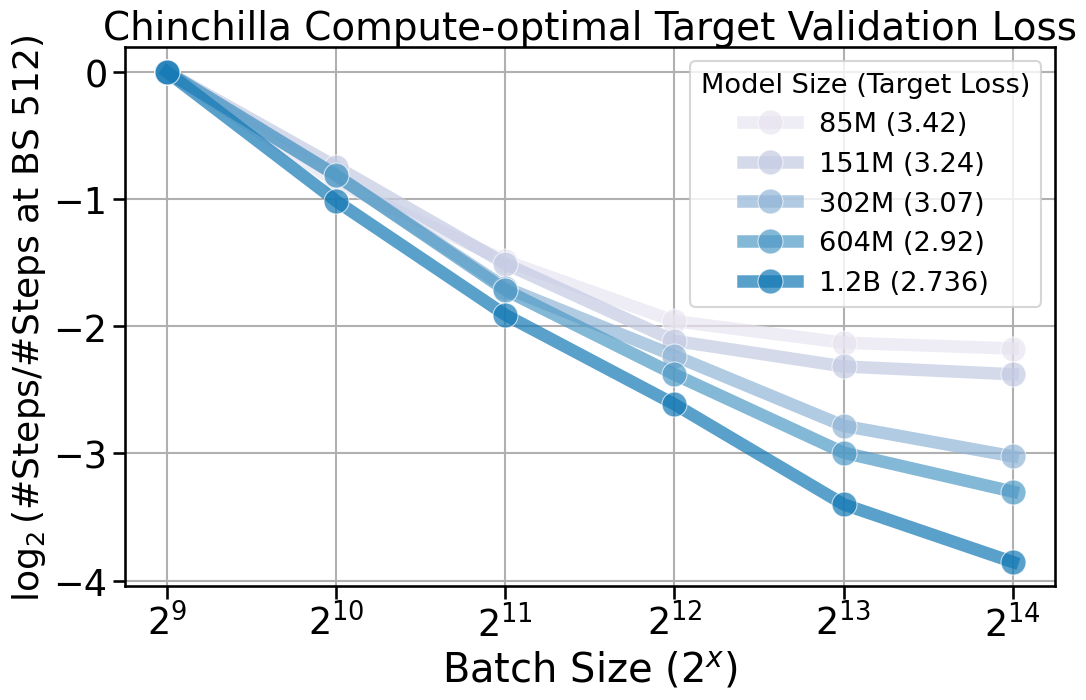

In [12]:
# Relative plots - making y-axis as # steps / # steps at batch size 64

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# replace np.inf with np.nan
for model_size in model_size_names:
    results[model_size] = [np.nan if x == np.inf else x for x in results[model_size]]

# first half
small_results = {}
large_results = {}
for model_size in model_size_names:
    small_results[model_size] = results[model_size][:5]
    large_results[model_size] = results[model_size][3:]

print(small_results)
print(large_results)
small_batch_sizes = batch_sizes[:5]
large_batch_sizes = batch_sizes[3:]

def main_plot(results, batch_sizes, goal_losses, legend_fontsize = 21, save_name='rel_model_size_chin', palette_name="Paired"):
    # NOTE Model size ablation on chinchilla validation loss
    all_plot_data = [
        {'batch_sizes': batch_sizes,
        'num_steps': results['85M'],
        'model_size': '85M',
        'goal_loss': goal_losses['85M']}, 
        {'batch_sizes': batch_sizes,
        'num_steps': results['151M-ablation'],
        'model_size': '151M',
        'goal_loss': goal_losses['151M-ablation']},
        {'batch_sizes': batch_sizes,
        'num_steps': results['302M'],
        'model_size': '302M',
        'goal_loss': goal_losses['302M']}, 
        {'batch_sizes': batch_sizes,
        'num_steps': results['604M'],
        'model_size': '604M',
        'goal_loss': goal_losses['604M']}, 
        {'batch_sizes': batch_sizes,
        'num_steps': results['1.2B'], 
        'model_size': '1.2B',
        'goal_loss': goal_losses['1.2B']},
    ]

    plt.figure(figsize=(12, 7))
    sns.set_palette(palette_name)  # Set a global color palette
    sns.set_context("talk", font_scale=1.6)
    plt.tight_layout()
    num_models = 5
    markers = ['o'] * num_models
    linewidths = [9] * num_models

    for data in all_plot_data:
        # Create a DataFrame
        df = pd.DataFrame(data)
        # Convert batch sizes to log2 scale
        df['log2_batch_sizes'] = np.log2(df['batch_sizes'])
        df['log2_num_steps'] = (np.log2(df['num_steps']) - np.log2(df['num_steps'][0]))
        plot = sns.lineplot(x='log2_batch_sizes', y='log2_num_steps', data=df, label=f'{df["model_size"][0]} ({df["goal_loss"][0]})',
                            alpha=.7, marker=markers[i], markersize=int(2*linewidths[i]), linewidth=linewidths[i])
        plot.set_xticks(df['log2_batch_sizes'])  # Set x-ticks to log2 batch sizes
        plot.set_xticklabels([f'$2^{{{int(x)}}}$' for x in df['log2_batch_sizes']])  # Format x-ticks with correct exponent format

    # Set labels and title
    smallest_batch_size = df['batch_sizes'][0]
    plt.xlabel('Batch Size ($2^x$)')
    plt.ylabel(fr'$\log_2$(#Steps/#Steps at BS {smallest_batch_size})', fontsize=26)
    plt.title('Chinchilla Compute-optimal Target Validation Loss', fontsize=28)
    plt.legend(title='Model Size (Target Loss)', loc='upper right', title_fontsize=legend_fontsize, fontsize=legend_fontsize)
    plt.grid(True)
    
    y_axes = np.arange(np.floor(min(df['log2_num_steps'])), np.ceil(max(df['log2_num_steps'])) + 1)
    plot.set_yticks(y_axes)

    plt.savefig(f'{save_name}.pdf', bbox_inches='tight')
    plt.show()

palette_name = "PuBu"
print(large_results)
large_results['85M'][-1] = 1550
main_plot(large_results, large_batch_sizes, goal_losses, legend_fontsize=19.6, save_name='rel_model_size_chin_large', palette_name=palette_name)

[64, 128, 256, 512, 1024]
{'85M': 3.42, '151M-ablation': 3.24, '302M': 3.07, '604M': 2.92, '1.2B': 2.736}


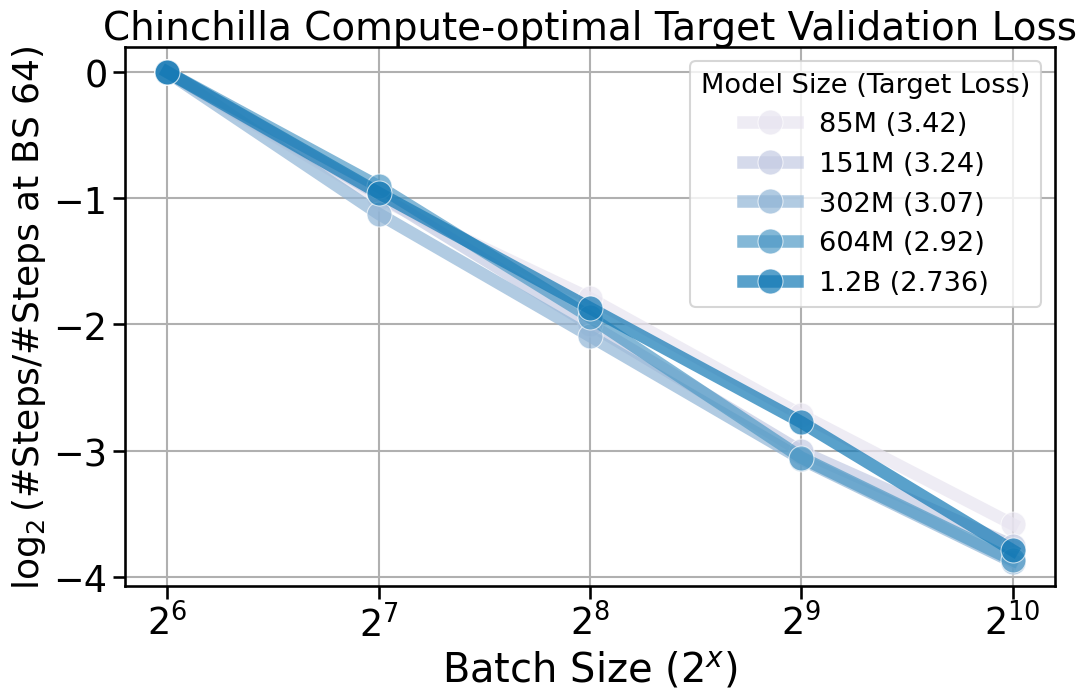

In [13]:
print(small_batch_sizes)
print(goal_losses)
main_plot(small_results, small_batch_sizes, goal_losses, legend_fontsize=19.6, save_name='rel_model_size_chin_small', palette_name=palette_name)

In [14]:
results = {'85M': [46000, 23000, 13282, 7000, 3840, 2528, 1917, 1600, 1600], '151M-ablation': [96000, 49000, 24000, 12000, 7128, 4350, 2940, 2400, 2300], '302M': [196000, 90000, 46000, 23400, 13300, 7224, 4980, 3400, 2879], '604M': [311000, 166000, 81000, 37440, 21320, 11400, 7199, 4700, 3800], '1.2B': [642000, 331000, 176000, 94000, 46500, 25000, 15360, 8900, 6500]}

import numpy as np
from scipy.optimize import curve_fit, fsolve

def log_power_law(x, a, b):
    return np.log(a + b * 1/x)

def two_param_cbs_law(x, d, beta):
    return d * 1/np.power(x, beta)

def log_three_param_cbs_law(x, c, d, beta):
    return np.log(c + d * 1/np.power(x,beta))

def log_two_param_cbs_law(x, d, beta):
    return np.log(d * 1/np.power(x, beta))

scaling_law_model_sizes = [85, 151, 302, 604, 1200]
model_size_names = ['85M', '151M-ablation', '302M', '604M', '1.2B']
batch_sizes = [2**i for i in range(6, 15)]
steps = [results[model_size] for model_size in model_size_names]

cbs_list = []
a_list, b_list, alpha_list = [], [], []
for model_size in model_size_names:
    print(f"Model Size: {model_size}")
    # Flatten model_sizes and batch_sizes for curve fitting
    batch_sizes_flat = batch_sizes
    steps_flat = results[model_size]
    print(batch_sizes_flat)
    print(steps_flat)
    # first fit Y = a + b * batch_size**(-alpha)
    popt, pcov = curve_fit(log_power_law, batch_sizes_flat, np.log(steps_flat), maxfev=5000) # (model_sizes, batch_sizes), steps)
    a, b = popt
    alpha = 1

    print(f"fitted log(Y) = log({a} + {b} * batch_size^(-{alpha}))")

    # then derive cbs: a = b*(cbs)^(-1*alpha) => cbs = (b/a)^(1/alpha)
    cbs = fsolve(lambda cbs: b - 5*a*cbs**alpha+5*a*1.2*256, 3)[0] # b - 5*a*cbs**alpha
    # cbs = fsolve(lambda cbs: b - 5*a*cbs-5*a*1.2*256, 3)[0] # 
    print(f"Critical batch size: {cbs} (log2: {np.log2(cbs)})")
    cbs_list.append(cbs)
    a_list.append(a)
    b_list.append(b)
    alpha_list.append(alpha)

print(scaling_law_model_sizes)
print(cbs_list)
# fit cbs w.r.t. model size: cbs = c + d * model_size**(-beta)
popt, pcov = curve_fit(log_three_param_cbs_law, scaling_law_model_sizes, np.log(cbs_list), maxfev=50000,
                       p0=[1000, 400, -1],  # Initial guesses for c, d, beta
                       bounds=([0, 0, -np.inf], [np.inf, np.inf, 0]))  # Constrain beta to be negative)
c, d, beta = popt
print(f"CBS log power law fitting (constrained): fitted log(cbs) = log({c} + {d} * model_size^({-1*beta}))")

popt, pcov = curve_fit(two_param_cbs_law, scaling_law_model_sizes, cbs_list, maxfev=5000)
d_two_plain, beta_two_plain = popt
print(f"CBS power law fitting (zero offset): fitted cbs = {d_two_plain} * model_size^({-1*beta_two_plain})")

popt, pcov = curve_fit(log_two_param_cbs_law, scaling_law_model_sizes, np.log(cbs_list), maxfev=5000)
d_two_log, beta_two_log = popt
print(f"CBS power law fitting (zero offset, log-scale): fitted log(cbs) = log({d_two_log} * model_size^({-1*beta_two_log}))")

Model Size: 85M
[64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
[46000, 23000, 13282, 7000, 3840, 2528, 1917, 1600, 1600]
fitted log(Y) = log(1293.8268694659337 + 2834258.0888740215 * batch_size^(-1))
Critical batch size: 745.3201466381583 (log2: 9.541716447236483)
Model Size: 151M-ablation
[64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
[96000, 49000, 24000, 12000, 7128, 4350, 2940, 2400, 2300]
fitted log(Y) = log(1752.4211962796799 + 5677478.783007255 * batch_size^(-1))
Critical batch size: 955.1582414387951 (log2: 9.899595954574608)
Model Size: 302M
[64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
[196000, 90000, 46000, 23400, 13300, 7224, 4980, 3400, 2879]
fitted log(Y) = log(2095.3497601960876 + 11383269.891870424 * batch_size^(-1))
Critical batch size: 1393.726947253441 (log2: 10.44473222719588)
Model Size: 604M
[64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
[311000, 166000, 81000, 37440, 21320, 11400, 7199, 4700, 3800]
fitted log(Y) = log(2459.9274969089824 + 1944968

/var/folders/b2/b8y78qq546ldsyx9xp1g56vm0000gn/T/ipykernel_54579/929901851.py:40: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  cbs = fsolve(lambda cbs: b - 5*a*cbs**alpha+5*a*1.2*256, 3)[0] # b - 5*a*cbs**alpha


In [15]:
cbs_list

[745.3201466381583,
 955.1582414387951,
 1393.726947253441,
 1888.5221009346358,
 2533.4108017868743]

In [16]:
# forecasting CBS
forecasting_model_sizes = [85, 151, 302, 604, 1200, 1500, 1750, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]
forecasted_cbs = [d_two_log * model_size**(-1*beta_two_log) for model_size in forecasting_model_sizes]
print("Formula: ", f"cbs = {d_two_log} * model_size^({-1*beta_two_log})")
for model_size, cbs in zip(forecasting_model_sizes, forecasted_cbs):
    print(f"Model Size: {model_size}, Forecasted CBS: {cbs} (log2: {np.log2(cbs)})")

Formula:  cbs = 93.196814043949 * model_size^(0.4682782328130422)
Model Size: 85, Forecasted CBS: 746.2871281420781 (log2: 9.54358699270694)
Model Size: 151, Forecasted CBS: 976.7165357571463 (log2: 9.931796111441145)
Model Size: 302, Forecasted CBS: 1351.2457305704816 (log2: 10.400074344254186)
Model Size: 604, Forecasted CBS: 1869.3909210511645 (log2: 10.86835257706723)
Model Size: 1200, Forecasted CBS: 2578.1882129770333 (log2: 11.332141871874875)
Model Size: 1500, Forecasted CBS: 2862.170282480187 (log2: 11.4828937912416)
Model Size: 1750, Forecasted CBS: 3076.416928928037 (log2: 11.587035321296044)
Model Size: 2000, Forecasted CBS: 3274.9265114580185 (log2: 11.677246817955039)
Model Size: 2500, Forecasted CBS: 3635.6528554516162 (log2: 11.827998737321764)
Model Size: 3000, Forecasted CBS: 3959.6906909833324 (log2: 11.95117202405464)
Model Size: 3500, Forecasted CBS: 4256.0918019538585 (log2: 12.055313554109086)
Model Size: 4000, Forecasted CBS: 4530.721355208049 (log2: 12.14552505

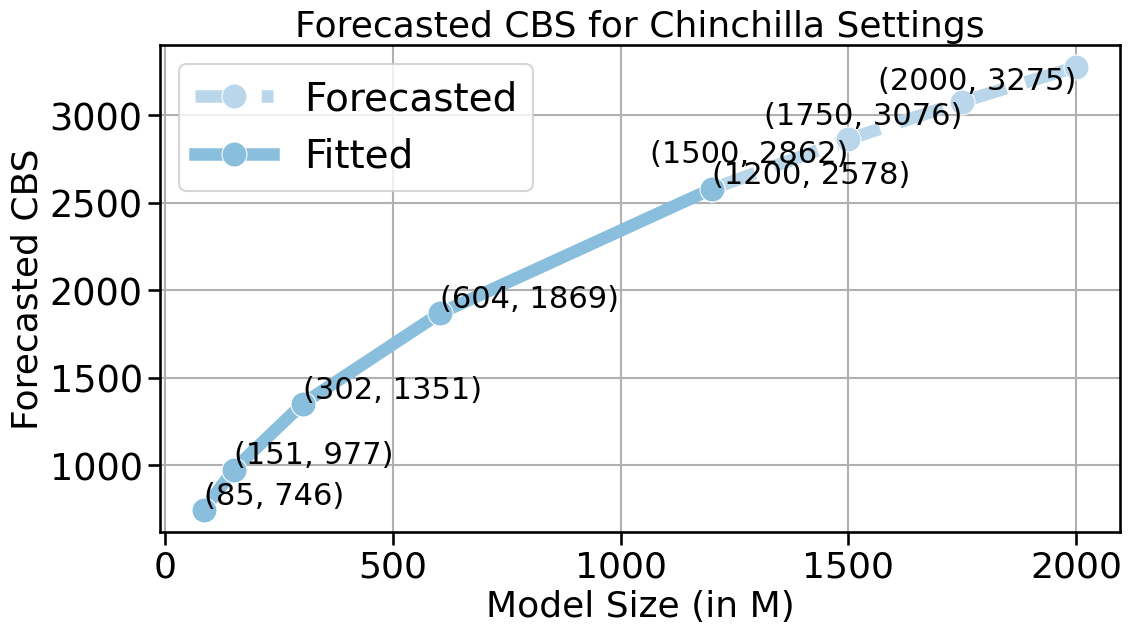

In [18]:
import seaborn as sns
# Data for plotting
data = {
    "Model Size": [85, 151, 302, 604, 1200, 1500, 1750, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000],
    "Forecasted CBS": forecasted_cbs, 
    "log2_num_steps": np.log2(forecasted_cbs) 
}

# Create dataframe
df = pd.DataFrame(data)
df_filtered = df[df['Model Size'] <= 2000]

# Re-plot with the requested changes
plt.figure(figsize=(12, 7))
palette_name = "Blues" 
palette = sns.color_palette(palette_name)


# Use dashed line for all points beyond 1200, including the first set of points
sns.lineplot(x=df_filtered["Model Size"][4:], y=df_filtered["Forecasted CBS"][4:], 
             marker="o", linestyle="--", color=palette[1], linewidth=9, markersize=18, label="Forecasted")

# Plot solid line for points below 1200
sns.lineplot(x=df_filtered["Model Size"][:5], y=df_filtered["Forecasted CBS"][:5], 
             marker="o", linestyle="-", color=palette[2], linewidth=9, markersize=18, label="Fitted")

# Add annotations for (x, y) values
text_font_size = 22
for i, (x, y) in enumerate(zip(df_filtered["Model Size"], df_filtered["Forecasted CBS"])):
    if i > 4:
        plt.text(x, y, f"({x}, {y:.0f})", fontsize=text_font_size, verticalalignment="bottom", ha='right', va='top')
        
    else:
        plt.text(x, y, f"({x}, {y:.0f})", fontsize=text_font_size, verticalalignment="bottom", )

legend_fontsize = 28
plt.legend(loc='upper left', title_fontsize=legend_fontsize, fontsize=legend_fontsize)

# Labels and title
plt.title('Forecasted CBS for Chinchilla Settings', fontsize=26)
plt.xlabel('Model Size (in M)',  fontsize=26)
plt.ylabel('Forecasted CBS', fontsize=26)
plt.xticks(fontsize=26)
plt.grid(True)

plt.savefig('chin_scaling_laws.pdf', bbox_inches='tight')
plt.tight_layout()

# Show plot
plt.show()
